This notebook goes through how I'm parsing the data one step at a time, for Patient GF101, Insulin1, Aug24-31. Hopefully I'll be able to get to the plotted graph by the end of this notebook.

In [1]:
# EVERYTHING WRT BOLUS

import pandas as pd
import numpy as np
import sys

u_cols = ['Date', 'Time', 'Timestamp','Bolus Type', 'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)', 'Sensor Glucose (mg/dL)']
filename = '670GF101_Insulin2_Carelink_SEP07-14_new.csv'
filename2 = 'Fiasp 670G Meal Scoring_MD Predictions.xlsx' #excel file
patient = filename[:5] + '-' + filename[5] + '-' + filename[6:8]
print (patient)

data = pd.read_csv(
                    filename, 
                    skiprows=range(11),
                    usecols=u_cols,
                    )
data['Date'] = pd.to_datetime(data['Date'])
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
begin_date = data.iloc[1]['Date']
end_date = data.iloc[-1]['Date']

# get bolus time
bolus = pd.read_excel(filename2, sheetname='Sheet1', parse_dates=[['Date', 'Time']])
bolus = bolus.loc[:, ~bolus.columns.str.contains('^Unnamed')]
bolus = bolus[(bolus['Subject'] == patient) & (bolus['Date_Time'] >= begin_date) & (bolus['Date_Time'] <= end_date) & (bolus['Meal'] == 'Breakfast')]
print(bolus.head())
# drop all the rows that don't give us any valuable information regarding blood glucose and insulin boluses
data = data.dropna(thresh=4)
data = data.reset_index()

670GF-1-01
            Date_Time     Subject  Week       Meal  Rating
3 2018-09-11 08:21:00  670GF-1-01     2  Breakfast       1


/Users/justinwang/anaconda3/envs/kundaje/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


I've loaded the csv into the DataFrame "data" using only the columns I deemed necessary. I also got rid of the first few rows because they aren't formatted the same way that the rest of the file is.

In [2]:
# off by one -- on Excel file indexing starts with 1, but indexing starts with 0 on pandas
data.head()

,index,Date,Time,Timestamp,Bolus Type,Bolus Volume Selected (U),Bolus Volume Delivered (U),Sensor Glucose (mg/dL)
0,17,2018-09-07,00:04:18,2018-09-07 00:04:18,NaN,NaN,NaN,146.0
1,27,2018-09-07,00:09:18,2018-09-07 00:09:18,NaN,NaN,NaN,147.0
2,37,2018-09-07,00:14:18,2018-09-07 00:14:18,NaN,NaN,NaN,148.0
3,47,2018-09-07,00:19:18,2018-09-07 00:19:18,NaN,NaN,NaN,148.0
4,57,2018-09-07,00:24:18,2018-09-07 00:24:18,NaN,NaN,NaN,148.0


      index       Date      Time           Timestamp Bolus Type  \
1876  13531 2018-09-11  07:24:38 2018-09-11 07:24:38        NaN   
1878  13542 2018-09-11  07:29:38 2018-09-11 07:29:38        NaN   
1880  13553 2018-09-11  07:34:38 2018-09-11 07:34:38        NaN   
1882  13564 2018-09-11  07:39:38 2018-09-11 07:39:38        NaN   
1884  13580 2018-09-11  07:44:38 2018-09-11 07:44:38        NaN   

      Bolus Volume Selected (U)  Bolus Volume Delivered (U)  \
1876                        NaN                         NaN   
1878                        NaN                         NaN   
1880                        NaN                         NaN   
1882                        NaN                         NaN   
1884                        NaN                         NaN   

      Sensor Glucose (mg/dL)        Time_delta  
1876                   143.0 -1 days +23:03:38  
1878                   147.0 -1 days +23:08:38  
1880                   153.0 -1 days +23:13:38  
1882                  

/Users/justinwang/anaconda3/envs/kundaje/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  


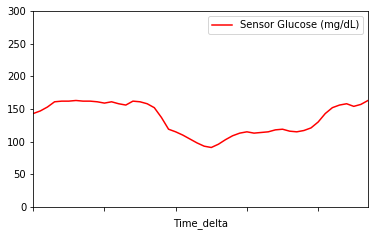

In [17]:
%matplotlib inline

import datetime
import matplotlib.pyplot as plt

meal = data[(data['Date'] == bolus.iloc[0]['Date_Time'].date())
             & (data['Timestamp'] >= bolus.iloc[0]['Date_Time'] - datetime.timedelta(hours=1)) 
             & (data['Timestamp'] <= bolus.iloc[0]['Date_Time'] + datetime.timedelta(hours=3))]
meal = meal.dropna(subset=['Sensor Glucose (mg/dL)'])
meal['Time_delta'] = meal['Timestamp'] - bolus.iloc[0]['Date_Time']
print(meal.head())

ax = meal.plot(kind='line', x ='Time_delta', y='Sensor Glucose (mg/dL)', color='red')
plt.ylim(0,300)
plt.show()

In [4]:
possible_baseline_glucoses = meal[(meal['Timestamp'] >= bolus.iloc[0]['Date_Time'] - datetime.timedelta(minutes=20)) & 
                                      (meal['Timestamp'] <= (bolus.iloc[0]['Date_Time'] + datetime.timedelta(minutes=5))) & 
                                      ((meal['Sensor Glucose (mg/dL)']).isnull() == False)]

baseline_glucose = 0
min_time_diff = datetime.timedelta(hours=1)
# for each possible baseline value, check which timestamp is closest to insulin bolus time
for index, possible_baseline in possible_baseline_glucoses.iterrows():
    time_diff = abs(possible_baseline['Timestamp'] - bolus.iloc[0]['Date_Time'])
    if time_diff < min_time_diff:
        min_time_diff = time_diff
        baseline_glucose = possible_baseline['Sensor Glucose (mg/dL)']


In [12]:
# within the next 1:30, we need to look for the maximum glucose level, minimum glucose level,
# don't forget to record the T_max and T_1/2max
bolus_time = meal.iloc[0]['Timestamp']
glucose_max = 0
delta_max = 0
T_max = 0
glucose_min = sys.maxsize
delta_min = 0
T_min = 0
T_halfmax = 0

meal_period = meal[(meal['Timestamp'] <= (bolus_time + datetime.timedelta(hours=1, minutes=30))) &
                      (meal['Timestamp'] >= bolus_time)]

for index, entry in meal_period.iterrows():
    if entry['Sensor Glucose (mg/dL)'] > glucose_max:
        glucose_max = entry['Sensor Glucose (mg/dL)']
        T_max = entry['Timestamp']
    if entry['Sensor Glucose (mg/dL)'] < glucose_min:
        glucose_min = entry['Sensor Glucose (mg/dL)']
        T_min = entry['Timestamp']

delta_max = glucose_max - baseline_glucose
delta_min = glucose_min - baseline_glucose

glucose_halfmax = baseline_glucose + delta_max / 2
for index, entry in meal_period.iterrows():
    # captures the first instance of a glucose reading at 1/2 max
    if (entry['Sensor Glucose (mg/dL)'] <= glucose_halfmax + 1) or (entry['Sensor Glucose (mg/dL)'] >= glucose_halfmax - 1):
        T_halfmax = entry['Timestamp']
        break

# add new columns 'Glucose_delta' and 'Time-delta' to plot later on
meal_period['Time_delta'] = meal_period['Timestamp'] - bolus_time
meal_period['Glucose_delta'] = meal_period['Sensor Glucose (mg/dL)'] - baseline_glucose

# calculating area under curve with scaled glucose values using numpy.trapz(array/list, dx)
# each glucose value isn't recorded at regular intervals, so how to deal with that?
# just using dx=1 for now
auc = np.trapz(list(meal_period['Glucose_delta'].dropna()), dx=1) 

result = [bolus, bolus_time, baseline_glucose, glucose_max, delta_max, T_max, glucose_min, delta_min, T_min, T_halfmax, auc]
print(result)
print(meal_period)

[            Date_Time     Subject  Week       Meal  Rating
3 2018-09-11 08:21:00  670GF-1-01     2  Breakfast       1, Timestamp('2018-09-11 07:24:38'), 161.0, 163.0, 2.0, Timestamp('2018-09-11 07:54:38'), 137.0, -24.0, Timestamp('2018-09-11 08:54:38'), Timestamp('2018-09-11 07:24:38'), -58.0]
      index       Date      Time           Timestamp Bolus Type  \
1876  13531 2018-09-11  07:24:38 2018-09-11 07:24:38        NaN   
1878  13542 2018-09-11  07:29:38 2018-09-11 07:29:38        NaN   
1880  13553 2018-09-11  07:34:38 2018-09-11 07:34:38        NaN   
1882  13564 2018-09-11  07:39:38 2018-09-11 07:39:38        NaN   
1884  13580 2018-09-11  07:44:38 2018-09-11 07:44:38        NaN   
1885  13590 2018-09-11  07:49:38 2018-09-11 07:49:38        NaN   
1886  13601 2018-09-11  07:54:38 2018-09-11 07:54:38        NaN   
1887  13616 2018-09-11  07:59:38 2018-09-11 07:59:38        NaN   
1889  13627 2018-09-11  08:04:38 2018-09-11 08:04:38        NaN   
1891  13638 2018-09-11  08:09:38 2

/Users/justinwang/anaconda3/envs/kundaje/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/justinwang/anaconda3/envs/kundaje/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<Figure size 432x288 with 0 Axes>

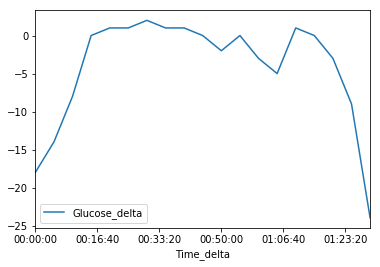

In [15]:
plt.figure()

meal_period_graph = meal_period.dropna(subset=['Glucose_delta'])
ax = meal_period_graph.plot(kind='line', x='Time_delta', y='Glucose_delta')